In [43]:
import os, sys
cwd = os.getcwd()
# sys.path.insert(0, f"{cwd}/../")
sys.path.insert(0, "/home/emmanuel/code/rbig")

# RBIG Packages
from rbig.data import ToyData
from rbig.layers import RBIGBlock, RBIGParams
from rbig.models import RBIGModel


from typing import Iterable, Optional, Dict, NamedTuple, Tuple, Union
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from rbig.base import DensityTransformerMixin, ScoreMixin

import numpy as np
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(["seaborn-paper"])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [44]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()

<Figure size 360x360 with 0 Axes>

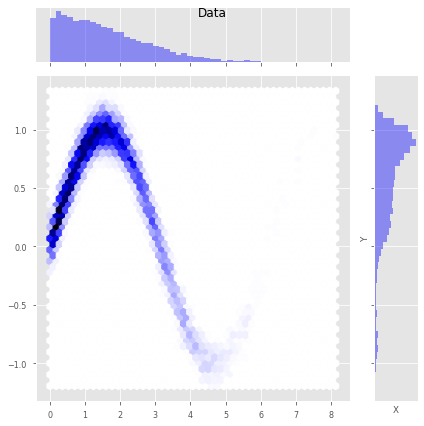

In [45]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 10_000
noise = 0.1
random_state=123
n_features = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state
).generate_samples()

plot_2d_joint(data, title='Data')

### Function: RBIG Block

This block represents the sequence of RBIG Transforms:

1. Marginal Gaussianization
2. Rotation

### Psuedo-Code

1. Add Flow to iterable
2. Do Transformation (MG + Rot)
3. Check CallBack
    * Stopping Criteria - hard stop after layers
    * Total Correlation - Calculate marginal entropy
    * Negative Log-Likelihood - score
4. Check Convergence
    * If Done: repeat steps 1-3
    * Else: End training

In [46]:
import collections

In [47]:
rbig_block = RBIGParams(rotation='pca')
# rbig_block.rotation = 'pca'

rbig_block = rbig_block.fit_data(data)
rbig_block

MG Params: nbins=100 alpha=1e-06 
Rotation Params: rotation=pca random_state=123 kwargs={}

<Figure size 360x360 with 0 Axes>

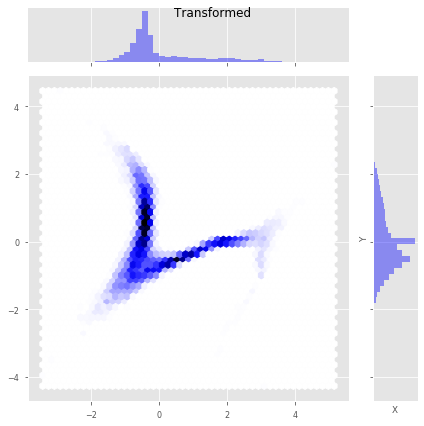

<Figure size 360x360 with 0 Axes>

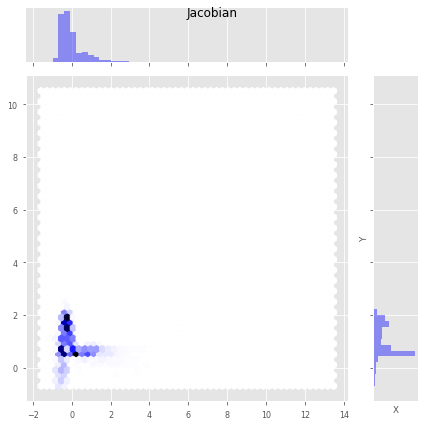

In [48]:

X_trans, dX_trans = rbig_block.transform(data, None, True)

plot_2d_joint(X_trans, title='Transformed')
plot_2d_joint(dX_trans, title='Jacobian')

<Figure size 360x360 with 0 Axes>

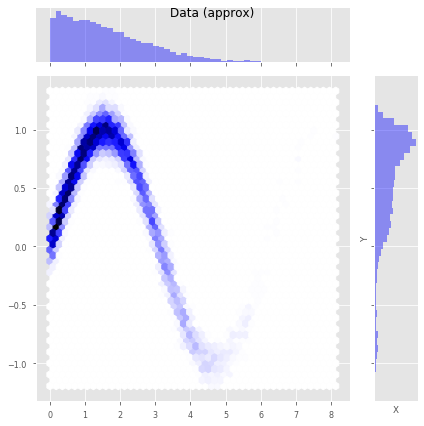

In [49]:
data_approx = rbig_block.inverse_transform(X_trans)
plot_2d_joint(data_approx, title='Data (approx)')

<Figure size 360x360 with 0 Axes>

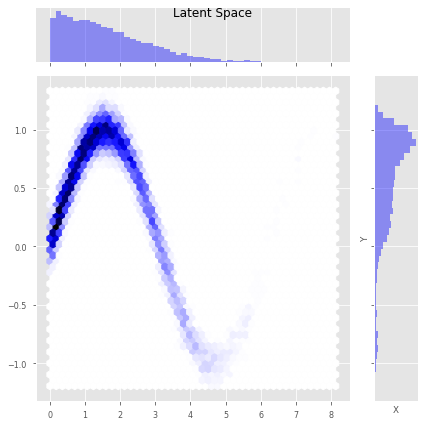

In [50]:
plot_2d_joint(data, title='Latent Space')



## 2. Multiple Layers

In [60]:
from rbig.losses import MaxLayers

# initialize params
rbig_params = RBIGParams()

# initialize rbig model
rbig_loss = MaxLayers(n_layers=50)

rbig_model = RBIGModel(rbig_params, rbig_loss)

In [64]:
Z_priorprob = stats.norm().rvs(Z.shape)

X_priorprob = stats.norm().logpdf(Z)

print(np.mean(Z_priorprob.sum(axis=1) - X_priorprob.sum(axis=1)))

2.837171906012615


### Viz - Forward Transformation, Latent Space Z

<Figure size 360x360 with 0 Axes>

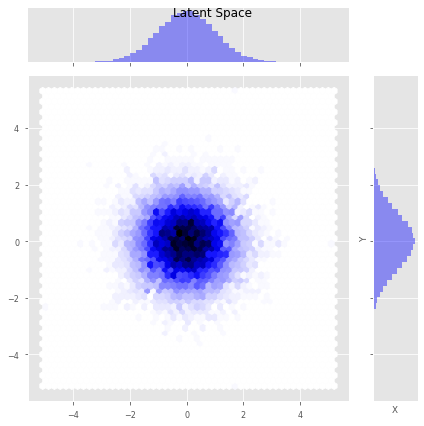

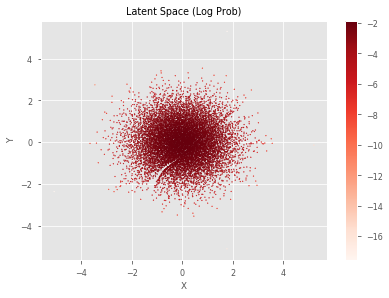

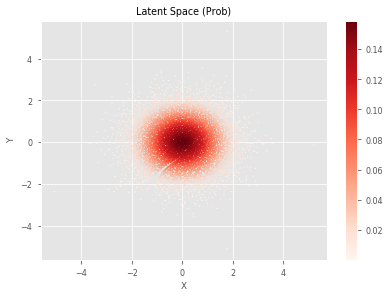

In [61]:
Z, X_slogdzet = rbig_model.fit_transform(data)
plot_2d_joint(Z, title='Latent Space')

X_priorprob = stats.norm().logpdf(Z)


plot_prob(Z, X_priorprob.sum(axis=1), title='Latent Space (Log Prob)')
plot_prob(Z, np.exp(X_priorprob.sum(axis=1)), title='Latent Space (Prob)')

### Viz - Inverse Transformation, Data Space X

<Figure size 360x360 with 0 Axes>

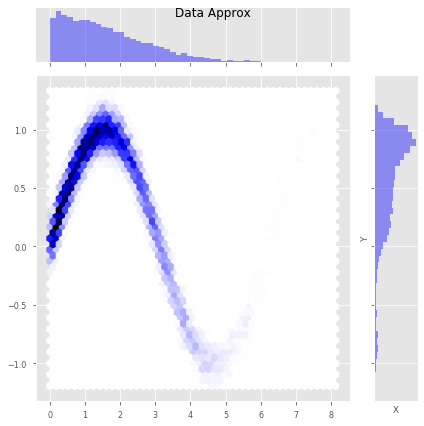

In [37]:
data_approx = rbig_model.inverse_transform(Z)
plot_2d_joint(data_approx, title='Data Approx')

### Viz - Sampling, Data Space X

<Figure size 360x360 with 0 Axes>

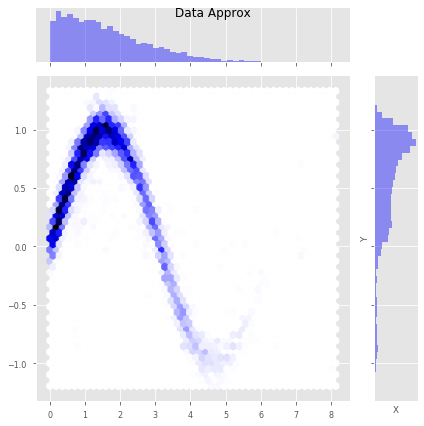

In [38]:
data_approx = rbig_model.sample(10_000)
plot_2d_joint(data_approx, title='Data Approx')

### Viz - Probabilities, Data Space X

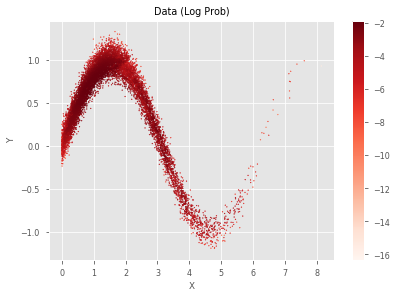

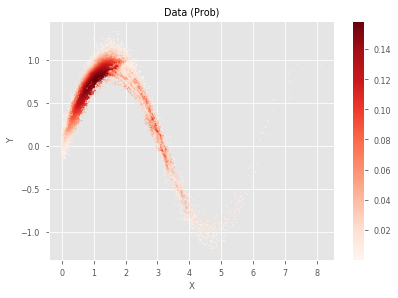

In [39]:
X_prob = rbig_model.score_samples(data)

plot_prob(data, X_prob, title='Data (Log Prob)')
plot_prob(data, np.exp(X_prob), title='Data (Prob)')

In [59]:
X_nll = rbig_model.score(data, None)
print('Negative Log-Likelihood:',X_nll)
print('Negative Likelihood:',np.exp(X_nll))

Negative Log-Likelihood: -3.2108585253856425
Negative Likelihood: 0.04032198096354374


### Viz - Negative Log-Likelihood

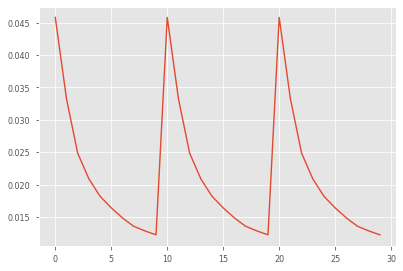

In [58]:
plt.plot(np.exp(rbig_model.losses_))

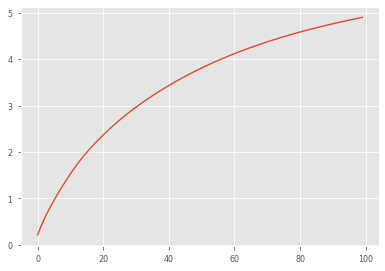

In [42]:
plt.plot(np.cumsum(np.exp(rbig_model.nll_loss)))